In [1]:
import numpy as np
import scipy
from scipy.integrate import quad
import scipy.constants as phys
import os
import matplotlib.pyplot as plt
import time

## 0. Initialize hyperparameters(E level, driving voltage..) and construct useful functions. 
<br>
<b>In this simulation, we calculate only the occupation probability $P_{(\text{hole}, \text{electron} | \text{site})} = x \in (0,1]$.</b> Therefore the first step requires : <br>

<br>
$P_{(\text{site|Given energy, potential})} \equiv $ <code>prob_intg(E, occ_function(EF, E0, Sig, field, arg, MAX = MAX_INT, MIN = MIN_INT))</code> <br><br>
Where <code>prob_intg()</code> is to calculate the principal part of fermi integration formlar. <br>
One thing we have to handle is when the field becomes under zero, i.e. when field direction is the opposite from the cathode, near the anode ; thus we copy, mask and exchange negative values to a very small value(must be positive, i chose 1 in the function), compared to average field strength($\geq 10^5 V/m$).
<br><br>

Next, <code>beta</code> is to account thermionic injection enhancement from the existing field. This is well-defined in the thesis of M.Schober : <a>https://tud.qucosa.de/landing-page/?tx_dlf[id]=https%3A%2F%2Ftud.qucosa.de%2Fapi%2Fqucosa%253A26282%2Fmets</a>
<br><br>
**args** in the functions retrieve character/strings that are not explicitly mentioned in the function. For example, <br>
<code>prob_intg(E, EF, E0, Sig, field, **"Hole"**, MAX = MAX_INT, MIN = MIN_INT)</code> will return the hole concentration probability(in HOMO)<br> in a **certain grid number**. Minority carriers and traps are neglected, i.e. p(x) in LUMO ~ 0. 

Occupation intg calc time : 0.004000186920166016
Enhancement calc time : 0.0010004043579101562


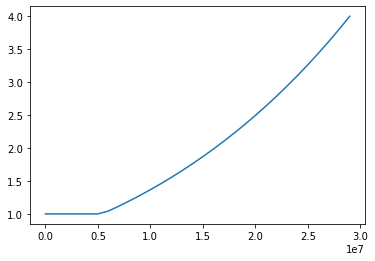

In [2]:
EF_ITO, EF_LiFAl   = -5.0, -3.3                                      # Each Fermi level(eV)
HOMO_NPD, LUMO_NPD, HOMO_Alq3, LUMO_Alq3 = -5.4, -2.4, -5.62, -2.85  # Each HOMO/LUMO level(eV)
SigH_NPD, SigL_NPD, SigH_Alq3, SigL_Alq3 = 0.1, 0.11, 0.15, 0.15     # Magnitude of disorders inlayers,(eV)
V_H = 3                                 # High voltage
kbT = 0.0258                            # (eV)
q  = 1.6022e-19
e0 = 8.8542e-12
er = 3.5
a  = 1.e-9                                   # Mean distance of intermolecular cite, (m)
ly, dx = 200, 1.e-9                          # total grid length and dx (None, m)
dtV  = dx**2/4                               # dt for V calculation, 2.5e-19 (s)       // Deprecated
dtP  = 1.e-16                                # dt for p calculation ~ 400*dtV (s)      // Deprecated
QdivE = q/e0/er                              # q/epsilon
f_const = q/(4*np.pi*e0*er*kbT**2)          # Constant for field normalization. kbT holds [eV].
Max_iter = int(1.e4)
MAX_INT, MIN_INT = 5,-15                     # Max and min value on fermi integral (eV)


##############################################################################################
# Integrating Occupation probability to account field-dependent injection in the             #
# interface of both electrodes. We hold negative notations for energy level representations. #
##############################################################################################
def occ_function(E, EF, E0, Sig, field, arg, MAX = MAX_INT, MIN = MIN_INT):
    e0, field = 0, field
    if field<=0:
        field = 1
        
    if arg == "Hole":
        e0 = E0 + np.sqrt(f_const*field)*kbT
        return 1/(1+np.exp(-(E-EF)/kbT))*np.exp(-(E-e0)**2/(2*Sig**2))
    else:
        e0 = E0 - np.sqrt(f_const*field)*kbT
        return 1/(1+np.exp((E-EF)/kbT))*np.exp(-(E-e0)**2/(2*Sig**2))

def prob_intg(EF, E0, Sig, field, *args, MAX = MAX_INT, MIN = MIN_INT):
    arg = args[0]
    if args[0] == "Hole":
        result = 1/np.sqrt(2*np.pi*Sig**2)*quad(occ_function, MIN, MAX, args=(EF, E0, Sig, field, arg))[0]
        #print("hole conc prob :", result, " Density :", result/a**3)
        return result
        
    elif args[0] == "Elec":
        result = 1/np.sqrt(2*np.pi*Sig**2)*quad(occ_function, MIN, MAX, args=(EF, E0, Sig, field, arg))[0]
        #print("electron conc prob :", result, " Density :", result/a**3)
        return result
    else:
        pass
##############################################################################################
# The field enhancement factor in thermionic injection.                                      #
##############################################################################################
def beta(field, *args):
    f = f_const*field
    if f<3.3317:                 # Since return fcn is concave, we select a threshold..
        return 1
    else:
        psi = 1/f+1/np.sqrt(f)-1/f*np.sqrt(1+2*np.sqrt(f))
        return (4*psi**2)*np.exp(np.sqrt(f))
    
start = time.time()
p0_NPD = prob_intg(EF_ITO, HOMO_NPD, SigH_NPD, 0, "Hole")       # Test for Anode interface concentration prob.
n0_LiFAl = prob_intg(EF_LiFAl, LUMO_Alq3, SigL_Alq3, 0, "Elec") # Test for cathode interface(Alq3-LiF/Al) ''

fin = time.time()
print("Occupation intg calc time :", fin-start)

start = time.time()
field_test = np.arange(0, 3.e7, 1.e6)
field_res  = [beta(i) for i in field_test]
fin = time.time()

# This shows the figure below. x : F[V/m], y : integer
plt.plot(field_test, field_res)
print("Enhancement calc time :", fin-start)

## 1. Now initialize initial parameters such as V(x), p(x), n(x), mu(x).

<br> 
x-axis in the figure below stands for the grid number. Since we assume intergrid distance as 1nm, the whole device thickness will be 200nm.
<br>

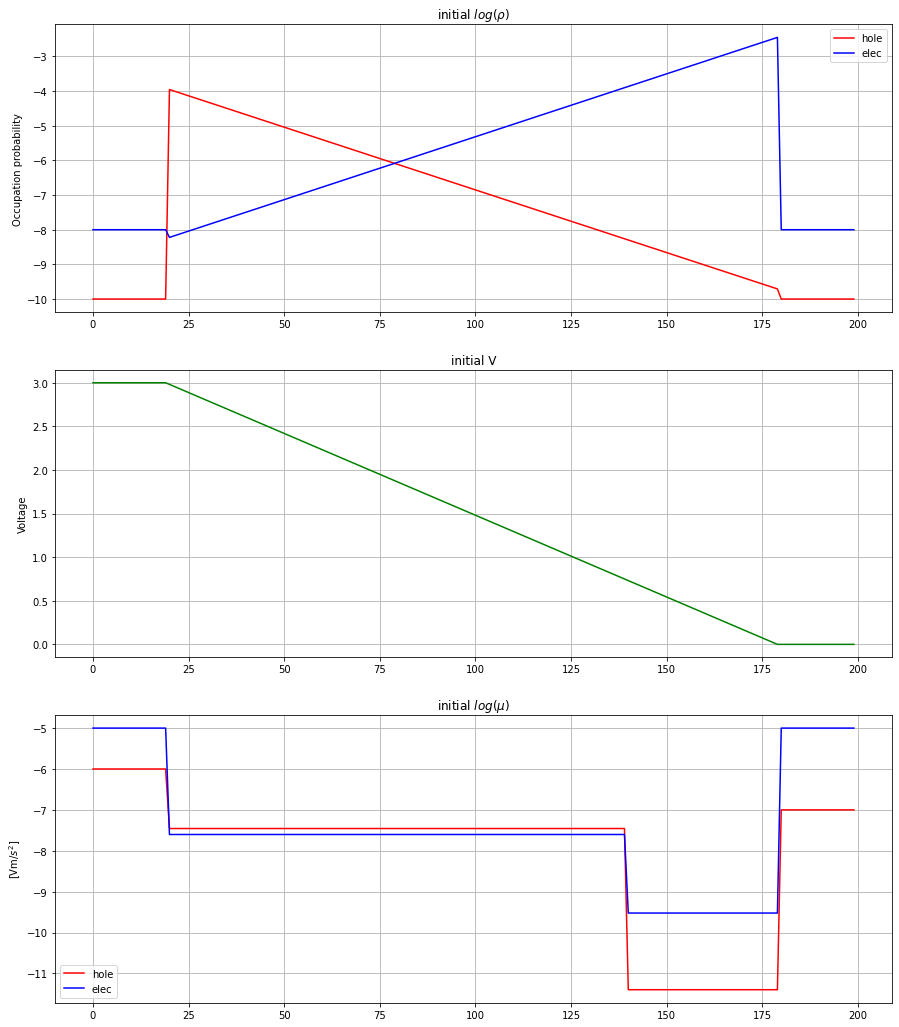

In [8]:
def world_init(V_H):
    ly, dx = 200, 1.e-9
    
    # Masks for each layer. for example, p[ETL] will return hole concentration probability in the ETL. 
    anode, cathode, HTL,ETL = np.zeros((4, ly), dtype = bool)
    anode[:20], HTL[20:140], ETL[140:180], cathode[180:] = True, True, True, True

    ####################################################################################################
    #                                         Initialization                                           #
    # mp0, mn0     == Zero-field, zero-concentration mobility of hole/electron                         #
    # pt, nt       == trap site hole/electron concentration probability                                #
    # p, n         == Free hole and electron ''                                                        #
    # SigHat_p, n  == Disorder/kbT for HOMO/LUMO                                                       #
    # SigH_, L_    == Homo/Lumo disodrder for each material in [eV]                                    #
    ####################################################################################################
    V, p, n, mp0, mn0, pt, nt, SigHat_p, SigHat_n = np.zeros((9,ly), dtype = np.float64) 
    # V, p/n density, mu0(T)_p/n, \rho(trap)_p/n, Normalized disorder. Electrodes are initialized as 2
    V_H = V_H
    V[anode], V[cathode] = V_H,0.
    # Electrode disorder 초기화. 
    SigHat_p[anode], SigHat_p[cathode], SigHat_n[anode], SigHat_n[cathode] = 2,2,2,2
    # 나머지 부분 disorder 초기화.
    SigHat_p[HTL], SigHat_p[ETL], SigHat_n[HTL], SigHat_n[ETL] = \
    SigH_NPD/kbT, SigH_Alq3/kbT, SigL_NPD/kbT, SigL_Alq3/kbT
    
    mp0[anode], mp0[HTL], mp0[ETL], mp0[cathode]= 1.e-6, 3.5e-8, 4.e-12, 1.e-7
    mn0[anode], mn0[HTL], mn0[ETL], mn0[cathode]= 1.e-5, 2.5e-8, 3.e-10, 1.e-5

    p[anode], p[cathode] = 1.e-10, 1.e-10
    n[anode], n[cathode] = 1.e-8, 1.e-8    
    
    ####################################################################################################
    # p, n : start from a log-linear profile to gaurantee convergence                                  #
    # V    : ''         linear-inear profile             ''                                            #
    # These profiles are empirically chosen with testing a variety of initial conditions               # 
    ####################################################################################################
    for i in range(20,180,1):
        p[i] = 10**((np.log10(p0_NPD)*(160-(i-20))+np.log10(p[-1]*V_H)*(i-20))/160)*V_H/5
        n[i] = 10**((np.log10(n[0])*(160-(i-20))+np.log10(n0_LiFAl*V_H)*(i-20))/160)*V_H/5
    for i in range(20,180,1):
        V[i] = V[0]*(179/160 - 1/160*i)
        

    fig, ax = plt.subplots(3,1,figsize = (15,18))
    X_ = np.arange(0,200,1)
    ax[0].plot(X_, np.log10(p), c = 'r', label = "hole")
    ax[0].plot(X_, np.log10(n), c = 'b', label = "elec")
    ax[0].set_title("initial "+r"$log(\rho)$")
    ax[0].set_ylabel("Occupation probability")
    ax[0].legend()
    ax[1].plot(X_, V, c = 'g')
    ax[1].set_title("initial V")
    ax[1].set_ylabel("Voltage")
    ax[2].plot(X_, np.log10(mp0), c = 'r', label="hole")
    ax[2].plot(X_, np.log10(mn0), c = 'b', label="elec")
    ax[2].set_title("initial "+r"$log(\mu)$")
    ax[2].set_ylabel(r"[Vm/$s^2$]")
    ax[2].legend()
    for axes_ in ax:
        axes_.grid()
    
    return V, p, n, mp0, mn0, pt, nt, SigHat_p, SigHat_n, anode, cathode, HTL, ETL

# Here's an example of the initial profile when V_H = 3V. 
V, p, n, mp0, mn0, pt, nt, SigHat_p, SigHat_n, anode, cathode, HTL, ETL = world_init(V_H)

## 2. Implement functions that are associated with the mobility.

<br> 
Straightforwardly, three functions are from $\mu \equiv \mu_{\text{(T,F = 0, p/n = 0)}} \cdot f_{(F)} \cdot g_{(p)}$
<br>

In [9]:
def delta(sig_p, sig_n, *args):
    if args[0] == "hole":
        return 2*(np.log(sig_p**2-sig_p) - 0.32663426)/sig_p**2
    elif args[0] == "elec":
        return 2*(np.log(sig_n**2-sig_n) - 0.32663426)/sig_n**2
    else:
        return "Error : Invalid Argument."
    
def g(hole, electron, sig_p, sig_n, *args):                  # 전극은 2로 초기화 // log(sigparam)-log(log(4)) >=0이 되게. 
    if args[0] == "hole":
        sigparam = sig_p**2-sig_p
        #print(sigparam)
        delta = 2*(np.log(sigparam) - 0.32663426)/sig_p**2
        return np.exp(0.5*sigparam*(2*hole)**delta)          # probability만 취급하니 a**3은 뗀다. 
    elif args[0] == "elec":
        sigparam = sig_n**2-sig_n
        delta = 2*(np.log(sigparam) - 0.32663426)/sig_n**2
        return np.exp(0.5*sigparam*(2*electron)**delta)
    else:
        return "Error : Invalid Argument."
# Fea/sig = dV / (sig(ev)) = dV/sigHat*kbT
def f(sig_p, sig_n, dV, *args):
    if args[0] == "hole":
        dV[dV>2*sig_p]= 2*sig_p[dV>2*sig_p]
        sigparam_1 = 0.44*(sig_p**1.5 - 2.2)
        sigparam_2 = np.sqrt(1+0.8*(dV/sig_p)**2)-1          # sig = disorder in eV.
        exponent   = sigparam_1*sigparam_2
        return np.exp(exponent)
    elif args[0] == "elec":
        dV[dV>2*sig_n]= 2*sig_n[dV>2*sig_n]
        sigparam_1 = 0.44*(sig_n**1.5 - 2.2)
        sigparam_2 = np.sqrt(1+0.8*(dV/sig_n)**2)-1          
        exponent   = sigparam_1*sigparam_2
        return np.exp(exponent)
    else:
        return "Error : Invalid Argument."

g_factor = g(p, n, SigHat_p, SigHat_n, "elec")
#print("Enhancement factor by concentration \n", g_factor)
dV_test = np.zeros_like(V)
dV_test[:-1] = V[1:]-V[:-1]
f_factor = f(SigHat_p, SigHat_n, dV_test, "elec")
#print("Enhancement factor by field \n", f_factor)
print("The Initial enhancement factor : \n", g_factor*f_factor)

The Initial enhancement factor : 
 [  1.03958878   1.03958878   1.03958878   1.03958878   1.03958878
   1.03958878   1.03958878   1.03958878   1.03958878   1.03958878
   1.03958878   1.03958878   1.03958878   1.03958878   1.03958878
   1.03958878   1.03958878   1.03958878   1.03958878   1.03959888
   1.07039848   1.07195947   1.07355625   1.0751897    1.07686071
   1.07857022   1.08031915   1.08210849   1.08393923   1.0858124
   1.08772904   1.08969025   1.09169713   1.09375083   1.09585252
   1.09800342   1.10020476   1.10245783   1.10476394   1.10712445
   1.10954074   1.11201425   1.11454646   1.11713888   1.11979307
   1.12251064   1.12529326   1.12814262   1.13106048   1.13404866
   1.13710902   1.14024348   1.14345402   1.14674269   1.1501116
   1.15356291   1.15709886   1.16072177   1.16443402   1.16823807
   1.17213647   1.17613183   1.18022685   1.18442435   1.1887272
   1.19313838   1.19766099   1.20229821   1.20705332   1.21192974
   1.21693099   1.22206071   1.22732267   1.

## 3. Run the simulation. 
<br>
Inputs  : V_H <br>
Outputs : Variables with "<code> *_fin</code>"

In [154]:
V_H_list = [0.1, 0.3, 0.5, 1]
####################################################################################################
#                   Results from the simulation. each variable represents :                        #
# p/n_fin    == Final concentration probability of hole/electron in the device                     #
# jp/jn_fin  == Final hole/electron "flux"                                                         #
# V_fin      == Final potential distribution                                                       #
# V_H_list   == V_H's that will be tested.                                                         #
#--------------------------------------------------------------------------------------------------#
# Usage : Look at the    # Storing    section in the cell below.                                   #
#         Variables are stored as, for example,                                                    #
# V_fin = {0.5 : [grid-wise voltage], 1 : [grid-wise voltage], key(V_H) : [grid-wise voltage...]}  #
# To get specific variables from certain driving voltages please use it as                         #
# Variable[V_H]. V_H is the key for the dictionary, and will return grid-wise variables.           #
####################################################################################################
V_fin    = {}                                    # final field 
p_fin    = {}                                    # 
n_fin    = {}
jp_fin   = {}                                    # final p current
jn_fin   = {}               

iterations : 15235
0.1 67.84892630577087
iterations : 16185
0.3 72.4086525440216
iterations : 17451
0.5 78.12981057167053
iterations : 21213
1 87.42794942855835


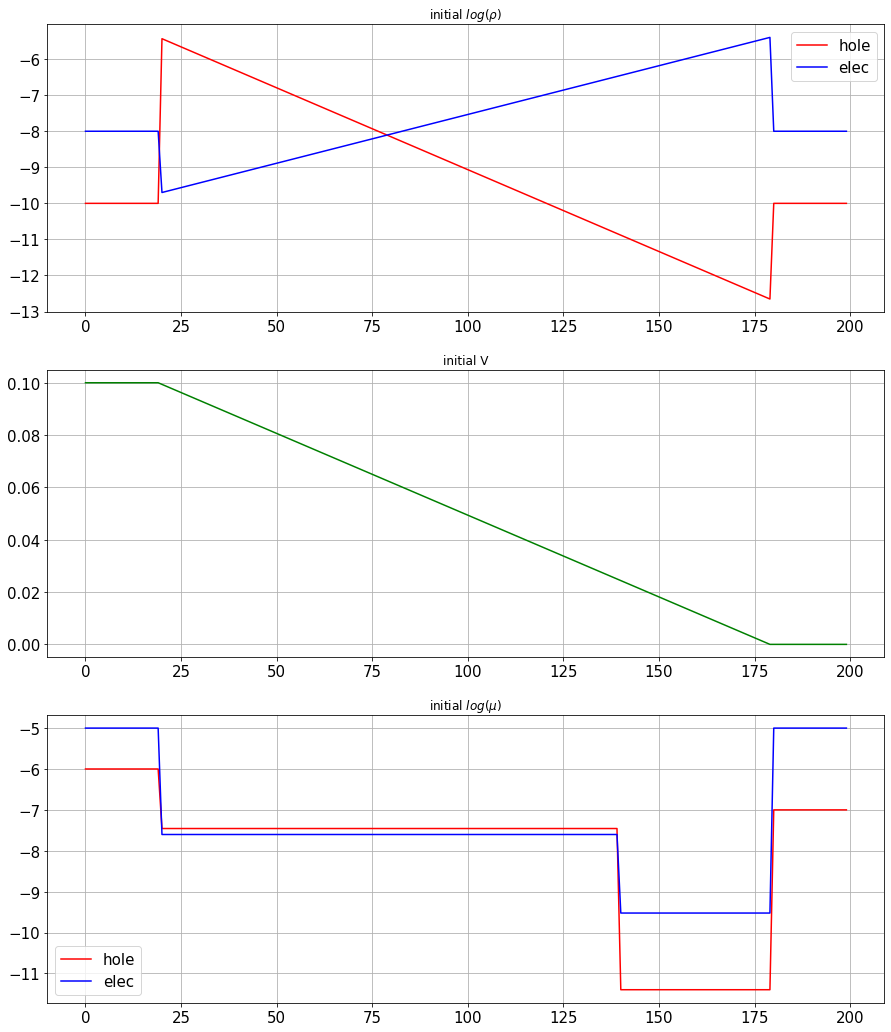

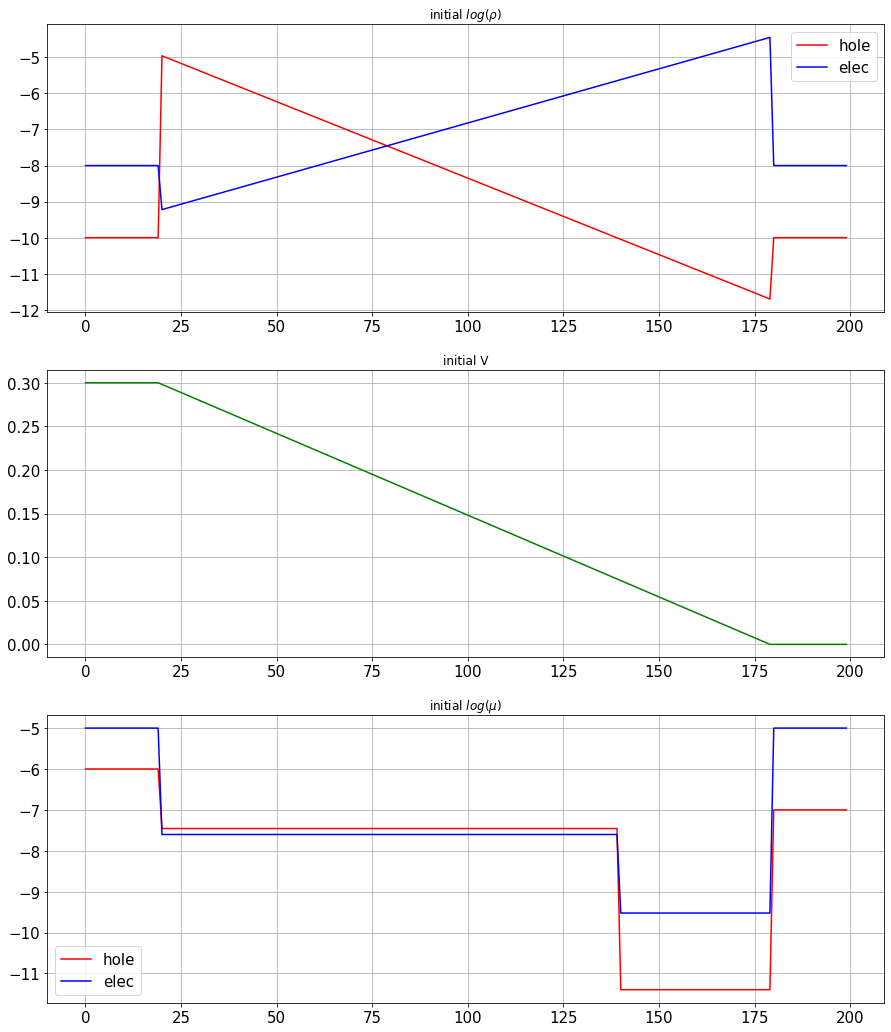

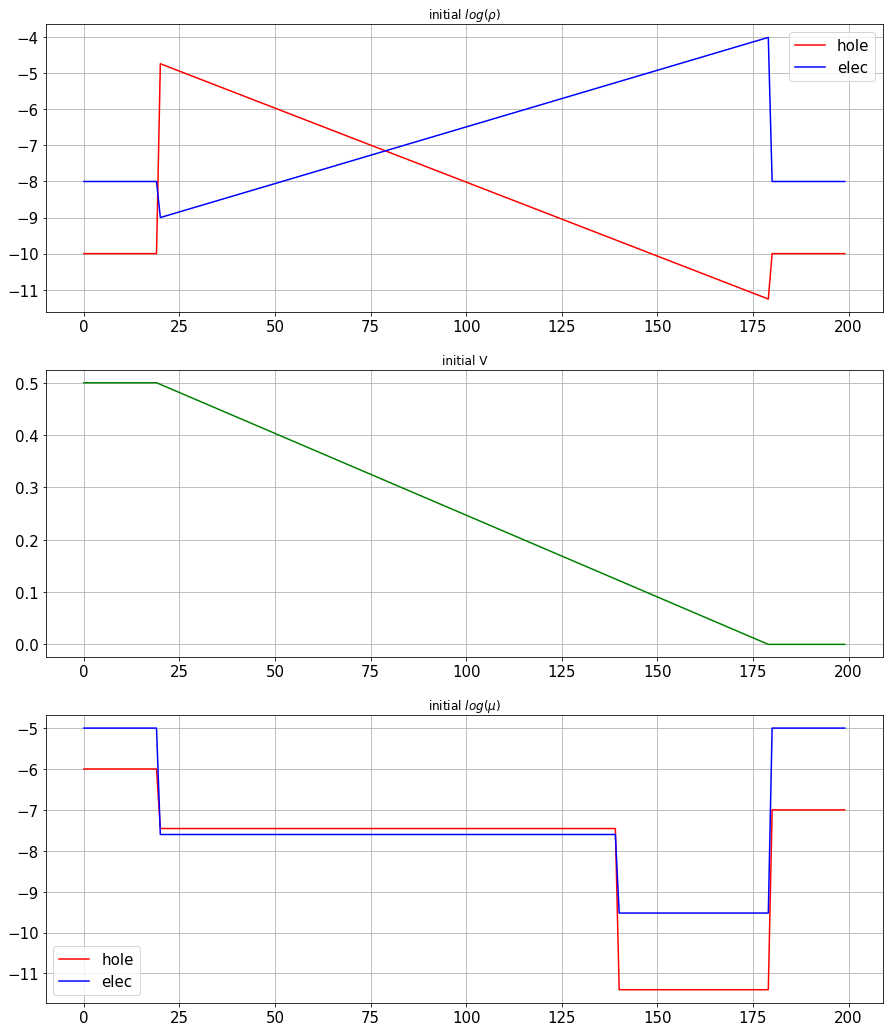

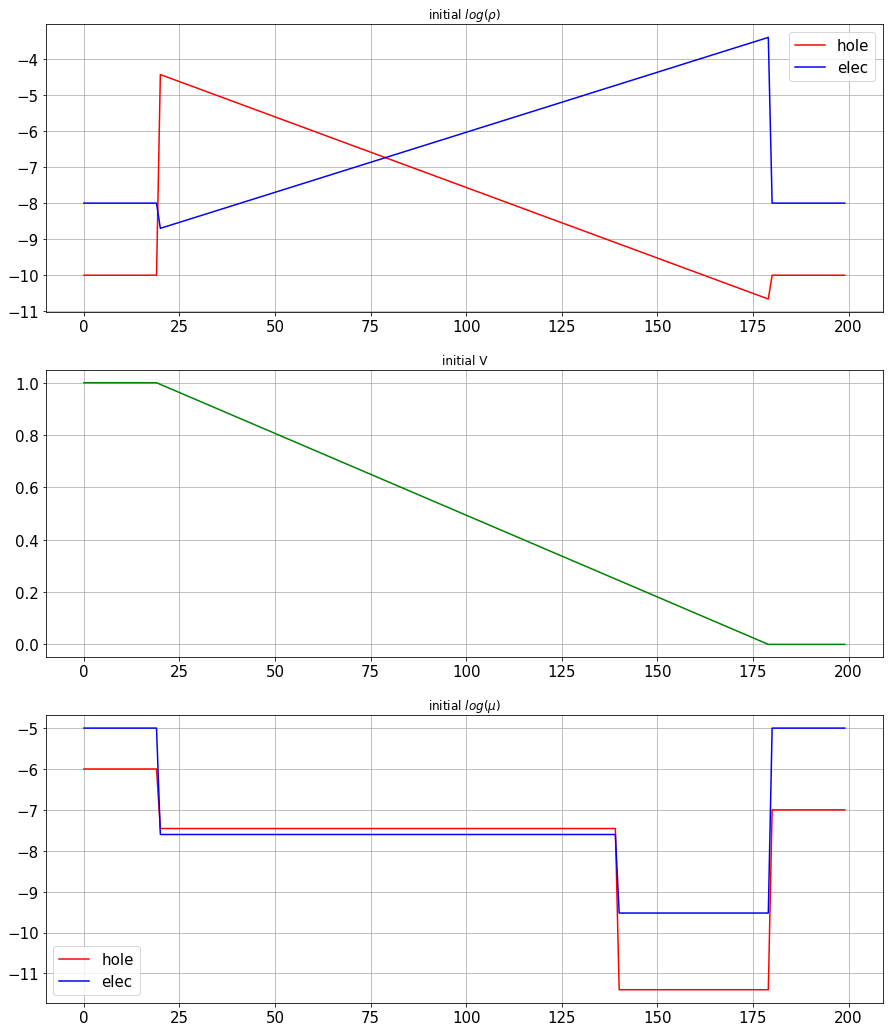

In [155]:
for V_H in V_H_list:
    
    # 0. Initialization.
    # THIS WILL RETURN INITIAL V, P, RHO PROFILES. THUS, IF THE INITIALIZATION SUCCEED, 
    # YOU WILL SEE THREE SUBPLOTS PER V_H. 
    
    V, p, n, mp0, mn0, pt, nt, SigHat_p, SigHat_n, anode, cathode, HTL, ETL = world_init(V_H)

    bound = [0,int(1000*V_H**1.2), int(1000*V_H**1.5)]
    start = time.time()
    rp_star    = kbT/dx**2*mp0              # Initial hopping rate.
    rn_star    = kbT/dx**2*mn0
    n0_anode_bound   = np.exp(-(LUMO_NPD - EF_ITO - SigL_NPD**2/2/kbT)/kbT)
    p0_cathode_bound = np.exp(-(EF_LiFAl - HOMO_Alq3 - SigH_Alq3**2/2/kbT)/kbT)
    threshold        = int(np.sqrt(V_H))*2000  # For smooth transition. 

    Max_iter = int(1.5e4*(1+V_H**1.5)**0.5)
    print("iterations :", Max_iter)
    for k in range(Max_iter):

        # 1. First, determine V with SOR method : O(N^1.5).
        post_V = np.zeros(ly, dtype = np.float64)

        for i in range(ly):
            if (i==0)|(i==199): post_V[i] = V[i]
            else:               post_V[i] = 0.5*(QdivE*(p[i]-n[i])*(dx**2/a**3) + V[i+1] + post_V[i-1]) # Occ prob로 들어가니 

        V = post_V
        V[cathode], V[anode] = 0,V_H

        # 2. Calculate field strength, and the hopping rate. 
        field = np.zeros(ly, dtype = np.float64)
        field[:-1] = -1*(V[1:] - V[:-1])/dx                 # F_i = -(V_i+1  -  V_i)/dx
        #field = -1*np.gradient(V, dx)

        g_factor_p = g(p, n, SigHat_p, SigHat_n, "hole")     # 여기 4개는 parallization 시켜도 괜찮을듯. 
        g_factor_n = g(p, n, SigHat_p, SigHat_n, "elec")
        f_factor_p = f(SigHat_p, SigHat_n, field*dx, "hole") # dV, 부호 상관없음. 
        f_factor_n = f(SigHat_p, SigHat_n, field*dx, "elec") 

        rp_param = rp_star*g_factor_p #*f_factor_p
        rp_plus  = rp_param*np.exp(field*dx/2/kbT)               # i -> i+1, hole
        rp_minus = np.zeros(ly, dtype = np.float64)
        rp_minus[1:] = rp_param[1:]*np.exp(-field[:-1]*dx/2/kbT) # i+1 -> i, hole
        rp_plus[139] = rp_minus[140]*np.exp(-0.22/kbT)            # 139->140
        rp_plus[19]  = 0                                          # Already we consider hole injections.
        rp_minus[20] = 0                                          # Injected holes seldom fall to cathode.
        rp_minus[180]= 0                                          # No holes run through cathode -> ETL.
        # f(F)에 문제가 있을 가능성. Shober랑 Coehoorn 모델 비교해 볼 것. 
        rn_param = rn_star*g_factor_n #*f_factor_n
        rn_plus  = rn_param*np.exp(-field*dx/2/kbT)               # i -> i+1, elec
        rn_minus = np.zeros(ly, dtype = np.float64)
        rn_minus[1:]  = rn_param[1:]*np.exp(field[:-1]*dx/2/kbT)  # i+1 -> i, elec
        rn_minus[140] = rn_plus[139]*np.exp(-0.45/kbT)
        #(mn0*f_factor_n*g_factor_n)[140]/(mn0*f_factor_n*g_factor_n)[139]            # 140->139
        rn_minus[180] = 0                                         # Already we consider injections.
        rn_plus[179]  = 0                                         # Injected electrons seldom fall to cathode.
        rn_plus[19]   = 0                                         # No electrons run through anode -> HTL.


        # 3. Calculate current and charge density in each gridpoint.
        j_p      = np.zeros(ly, dtype = np.float64)
        j_p[:-1] = rp_plus[:-1]*p[:-1] - rp_minus[1:]*p[1:]
        #rp_minus[cathode] = 0
        p_new                = np.zeros(ly, dtype = np.float64)
        p_new[1:-1]          = (rp_plus[:-2]*p[:-2] + rp_minus[2:]*p[2:])/(rp_plus[1:-1] + rp_minus[1:-1])


        j_n      = np.zeros(ly, dtype = np.float64)
        j_n[:-1] = rn_minus[1:]*n[1:] - rn_plus[:-1]*n[:-1]
        n_new                = np.zeros(ly, dtype = np.float64)
        n_new[1:-1]          = (rn_plus[:-2]*n[:-2] + rn_minus[2:]*n[2:])/(rn_plus[1:-1] + rn_minus[1:-1])

        dp, dn               = 0, 0

        if k<bound[1]:                                            # To compansate numerical unstability, 
            dp = (p_new-p)/(p_new+p)*p/((10+V_H)**1.7)
            dn = (n_new-n)/(n_new+n)*n/((10+V_H)**1.7)
        elif bound[1]<=k<bound[2]:
            dp = (p_new-p)/(p_new+p)*p/((5+V_H)**1.2)
            dn = (n_new-n)/(n_new+n)*n/((5+V_H)**1.2)
        else:
            dp = (p_new-p)/(p_new+p)*p
            dn = (n_new-n)/(n_new+n)*n

        p                   += dp
        n                   += dn
        # Initialize charge density of electrodes
        p[anode], p[cathode] = 1.e-5, 1.e-5                        # Free electron and holes will share the same portion. 
        n[anode], n[cathode] = 1.e-5, 1.e-5
        if k>threshold:
            beta_anode   = beta(np.mean(field[20]))
            beta_cathode = beta(np.mean(field[179]))
            p[20]                = prob_intg(EF_ITO, HOMO_NPD, SigH_NPD, field[20], "Hole")*beta_anode
            n[179]               = prob_intg(EF_LiFAl, LUMO_Alq3, SigL_Alq3, field[179], "Elec")*beta_cathode

    fin = time.time()
    print("Deiving voltage = ", V_H, " Calculation time = ",fin-start)

    # Storing 
    V_fin[V_H] = V
    p_fin[V_H] = p
    n_fin[V_H] = n
    jp_fin[V_H] = j_p
    jn_fin[V_H] = j_n

In [156]:
beta(field[179])

1

In [157]:
mp0[139:141]

array([3.5e-08, 4.0e-12])

In [158]:
ptest = mp0*g_factor_p*f_factor_p
ntest = mn0*g_factor_n*f_factor_n
print(ptest[139:141], ntest[139:141])

[1.57916868e-07 1.06358286e-11] [2.54034006e-08 8.17088899e-08]


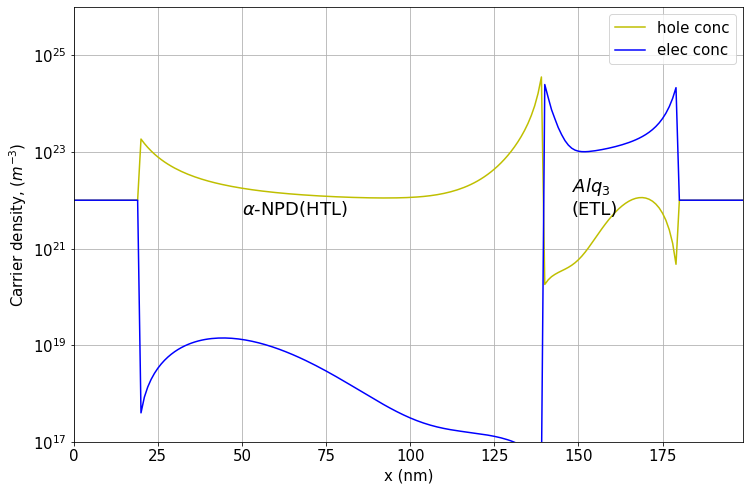

In [160]:
# Charge concentration profiles. 

plt.figure(figsize=(12, 8))
plt.plot(np.arange(0,200,1), p_fin[0.5]/a**3, c = 'y', label = "hole conc")
plt.plot(np.arange(0,200,1), n_fin[0.5]/a**3, c = 'b', label = "elec conc")
#plt.ylim(1.e15, 5.e26)
plt.yscale('log')
plt.ylim(1.e17, 1.e26);plt.xlim(0,199)
plt.xlabel("x (nm)");plt.ylabel("Carrier density, "+r'$(m^{-3})$')
plt.text(50, 5.e21, r"$\alpha$"+"-NPD(HTL)", fontsize = 18)
plt.text(148, 5.e21, r"$Alq_3$"+"\n(ETL)", fontsize = 18)
plt.rc('ytick', labelsize=15);plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
plt.legend()
plt.grid()

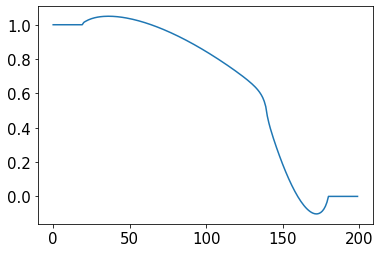

In [161]:
# Final voltage. 
plt.plot(np.arange(0,200,1), V)

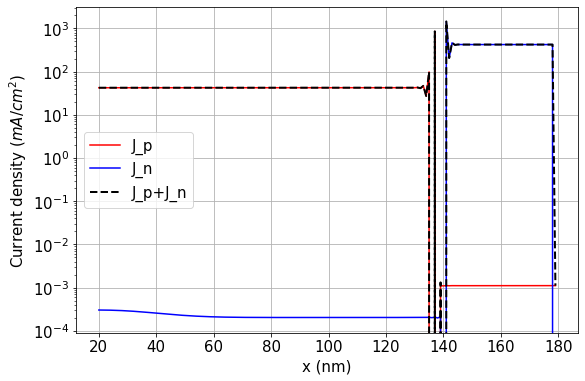

In [179]:
plt.figure(figsize=(9, 6))

# Get the total current in each grid. 
J_tot = (j_p+j_n)*q/a**2

plt.plot(np.arange(20,180,1), j_p[20:180]*q/a**2/10,c = 'r', label = 'J_p')
plt.plot(np.arange(20,180,1), j_n[20:180]*q/a**2/10,c = 'b', label = 'J_n')
plt.plot(np.arange(20,180,1),J_tot[20:180]/10, c = 'k', linewidth = 2, linestyle = '--', label = 'J_p+J_n')
plt.xlabel("x (nm)");plt.ylabel("Current density "+r"$(mA/cm^2)$")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

In [163]:
# TOTAL CURRENT IN mA/cm^2 #

np.mean(J_tot[22:177])

818.3800574050479